In [1]:
!pip install pydot

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow_addons as tfa
import tensorflow as tf
from IPython import display

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
#   "/home/tony/TO_BE_REMOVED/celeba_data/imgs/",
  "/Users/anthonylaw/Desktop/Endless/GAN-devel/datasets/afhq/train",
  seed=123,
  image_size=(256, 256),
  batch_size=2)

Found 14630 files belonging to 3 classes.


2022-09-11 16:38:16.662151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
K=len(train_ds.class_names)
print(K)

3


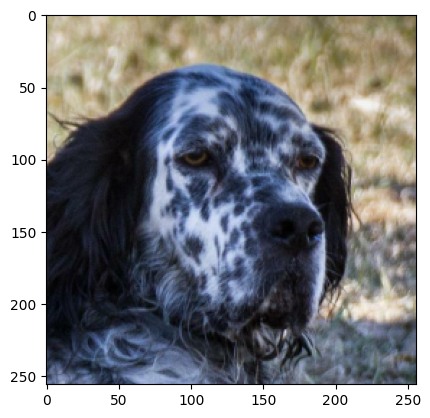

In [5]:
for img, l in train_ds.take(1):
#     print(tf.cast(tf.math.round(img[0]), dtype=tf.int32))
    plt.imshow(tf.cast(tf.math.round(img[0]), dtype=tf.int32))

### Img to Img Generator with style code injection

#### Note:

Implemented with Pre-Act ResBlk

In [98]:
class Generator(Model):
    
    def __init__(self, image_shape_in, image_shape_out, num_channel, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.image_shape_out = image_shape_out
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()
        self.add4 = layers.Add()
        self.add5 = layers.Add()
        self.add6 = layers.Add()
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(32, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 IN
        self.rb1_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl1 = layers.ReLU()
        self.rb1_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl2 = layers.ReLU()
        self.rb1_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        # resblk 2 IN
        self.rb2_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl1 = layers.ReLU()
        self.rb2_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl2 = layers.ReLU()
        self.rb2_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        
        # resblk 3 IN
        self.rb3_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl1 = layers.ReLU()
        self.rb3_conv2d1 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl2 = layers.ReLU()
        self.rb3_conv2d2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # resblk 4 AdaIN
        self.rb4_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl1 = layers.ReLU()
        self.rb4_conv2d1 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb4_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl2 = layers.ReLU()
        self.rb4_conv2d2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # resblk 5 AdaIN
        self.rb5_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb5_rl1 = layers.ReLU()
        self.rb5_conv2d1 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb5_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb5_rl2 = layers.ReLU()
        self.rb5_conv2d2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 1
        self.us1 = layers.Conv2DTranspose(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 6 AdaIN
        self.rb6_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb6_rl1 = layers.ReLU()
        self.rb6_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb6_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb6_rl2 = layers.ReLU()
        self.rb6_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 2
        self.us2 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        
        # out conv 1x1
        self.out_conv11 = layers.Conv2D(3, (1, 1),
                                        strides=(1, 1), padding='same')
            
        
    def call(self, img_in, s_c):
        # conv 1x1
        mu_sc = tf.reduce_mean(s_c)
        sigma_sc = tf.math.reduce_std(s_c)
        
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(self.rb1_in1(x)))
        x_res = self.rb1_conv2d2(self.rb1_rl2(self.rb1_in2(x_res)))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(self.rb2_in1(x)))
        x_res = self.rb2_conv2d2(self.rb2_rl2(self.rb2_in2(x_res)))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # resblk 3
        x_res = self.rb3_conv2d1(self.rb3_rl1(self.rb3_in1(x)))
        x_res = self.rb3_conv2d2(self.rb3_rl2(self.rb3_in2(x_res)))
        x = self.add3([x, x_res])
        
        # resblk 4 AdaIN
        x_res = self.rb4_conv2d1(self.rb4_rl1(tf.math.add(tf.math.multiply(self.rb4_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb4_conv2d2(self.rb4_rl2(tf.math.add(tf.math.multiply(self.rb4_in2(x_res), sigma_sc), mu_sc)))
        x = self.add4([x, x_res])

        # resblk 5 AdaIN
        x_res = self.rb5_conv2d1(self.rb5_rl1(tf.math.add(tf.math.multiply(self.rb5_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb5_conv2d2(self.rb5_rl2(tf.math.add(tf.math.multiply(self.rb5_in2(x_res), sigma_sc), mu_sc)))
        x = self.add5([x, x_res])

        # resblk 5 upsample
        x = self.us1(x)

        # resblk 6 AdaIN
        x_res = self.rb6_conv2d1(self.rb6_rl1(tf.math.add(tf.math.multiply(self.rb6_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb6_conv2d2(self.rb6_rl2(tf.math.add(tf.math.multiply(self.rb6_in2(x_res), sigma_sc), mu_sc)))
        x = self.add6([x, x_res])

        # resblk 6 upsample
        x = self.us2(x)
        
        # conv 1x1 out
        x = self.out_conv11(x)
        
        return x
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        sc = tf.random.normal((64,))
        return Model(inputs=x, outputs=self.call(x,sc))
        

#### Testing

In [99]:
g_t = Generator((256,256),(256,256),3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


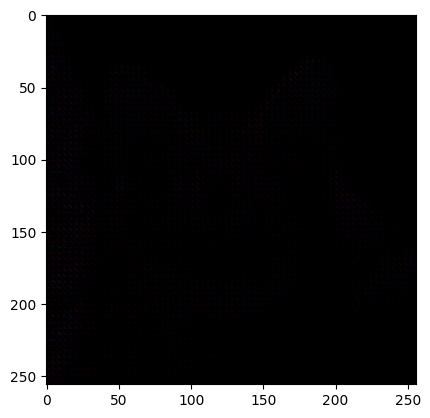

In [100]:
for img, l in train_ds.take(1):
    img = g_t(img, tf.random.normal((64,)))
    plt.imshow(tf.cast(tf.math.round(img[1]), dtype=tf.int32))

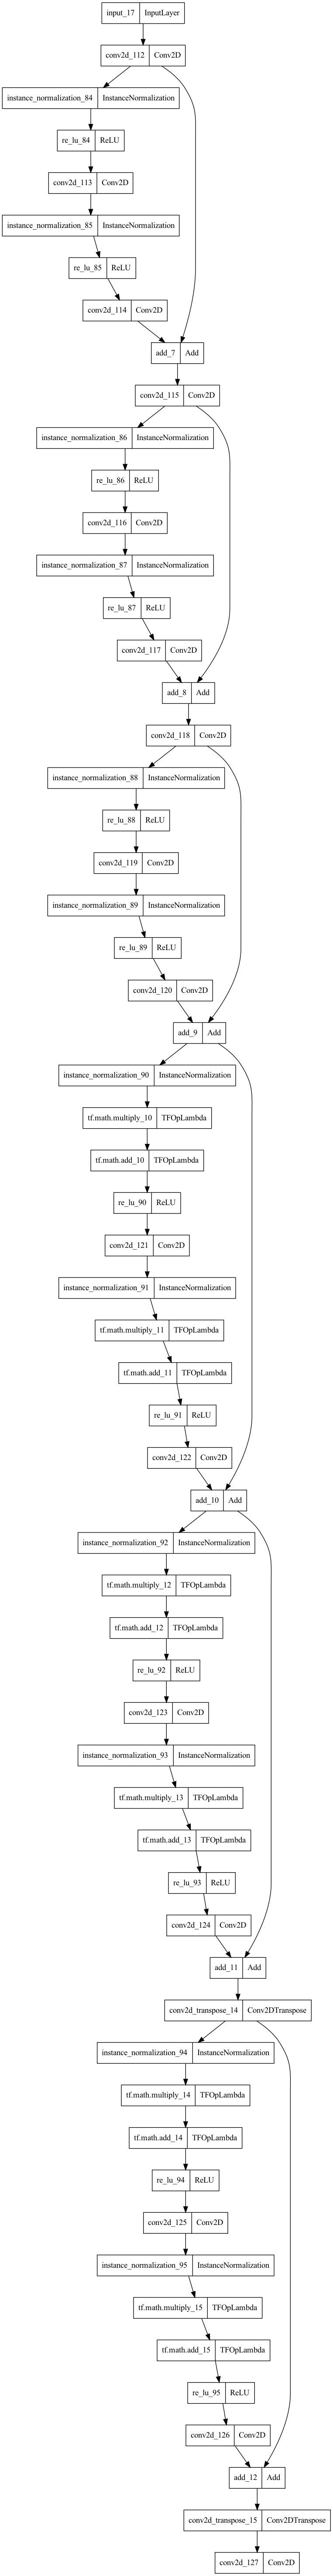

In [101]:
tf.keras.utils.plot_model(g_t.build_graph())

In [102]:
g_t.summary()

Model: "generator_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 add_7 (Add)                 (None, 256, 256, 32)      0         
                                                                 
 add_8 (Add)                 (None, 128, 128, 64)      0         
                                                                 
 add_9 (Add)                 (None, 64, 64, 128)       0         
                                                                 
 add_10 (Add)                (None, 64, 64, 128)       0         
                                                                 
 add_11 (Add)                (None, 64, 64, 128)       0         
                                                                 
 add_12 (Add)                (None, 128, 128, 64)      0         
                                                                 
 conv2d_112 (Conv2D)         (None, 256, 256, 32)      

### Mapping Network

In [114]:
class Mapper(Model):

    def __init__(self, num_domains, sc_dims):
        super().__init__()
        self.sl1 = layers.Dense(256, activation="relu")
        self.sl2 = layers.Dense(256, activation="relu")
        self.domain_layers = []
        for i in range(num_domains):
            self.domain_layers.append([layers.Dense(256, activation="relu"), 
                                       layers.Dense(sc_dims, activation="relu")])
            
    def call(self, latent_code):

        x = self.sl1(latent_code)

        x = self.sl2(x)

        xs = []
        for dl in self.domain_layers:
            xs.append(dl[1](dl[0](x)))

        return xs

    def build_graph(self):
        x = layers.Input(shape=(16,))
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [119]:
mapper1 = Mapper(4, 64)

In [120]:
sc_1 = mapper1(tf.random.normal((2,16)))
print(sc_1)

[<tf.Tensor: shape=(2, 64), dtype=float32, numpy=
array([[0.        , 0.03102421, 0.        , 0.        , 0.15166917,
        0.16373873, 0.05373181, 0.        , 0.03519676, 0.01891965,
        0.01993183, 0.03599719, 0.        , 0.06648187, 0.04916069,
        0.00691744, 0.        , 0.        , 0.        , 0.07357916,
        0.        , 0.        , 0.10465692, 0.0920442 , 0.        ,
        0.        , 0.        , 0.05022134, 0.19471616, 0.        ,
        0.15489744, 0.        , 0.        , 0.03599045, 0.11847521,
        0.        , 0.04560667, 0.        , 0.02225181, 0.03494792,
        0.        , 0.        , 0.        , 0.        , 0.01121682,
        0.183094  , 0.11128145, 0.        , 0.01202557, 0.06646372,
        0.03130817, 0.06325638, 0.        , 0.06462375, 0.0158723 ,
        0.00998419, 0.00941347, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06533201],
       [0.        , 0.        , 0.        , 0.        , 0.11940198,
        0

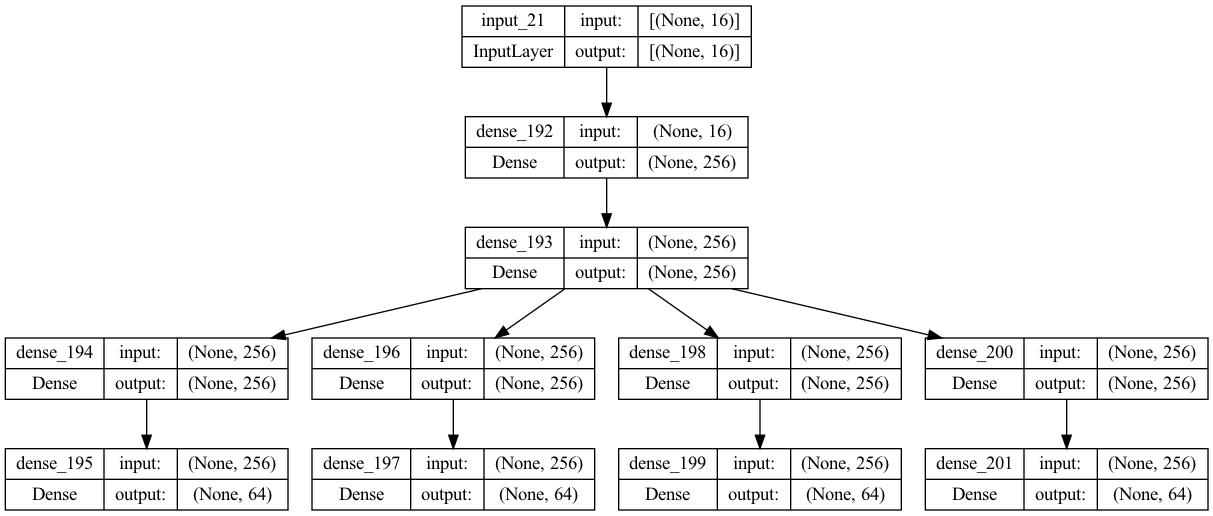

In [121]:
tf.keras.utils.plot_model(mapper1.build_graph(), show_shapes=True)

In [122]:
mapper1.summary()

Model: "mapper_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 256)               4352      
                                                                 
 dense_193 (Dense)           (None, 256)               65792     
                                                                 
 dense_194 (Dense)           (None, 256)               65792     
                                                                 
 dense_195 (Dense)           (None, 64)                16448     
                                                                 
 dense_196 (Dense)           (None, 256)               65792     
                                                                 
 dense_197 (Dense)           (None, 64)                16448     
                                                                 
 dense_198 (Dense)           (None, 256)               65

### Style Encoder

In [ ]:
class StyleEncoder(Model):
    
    def __init__(self, image_shape_in, sc_dims, num_channel, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.sc_dims = sc_dims
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()

        # in conv 1x1
        self.in_conv11 = layers.Conv2D(32, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 IN
        self.rb1_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl1 = layers.ReLU()
        self.rb1_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl2 = layers.ReLU()
        self.rb1_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

     
        
    def call(self, img_in, s_c):
        # conv 1x1
        mu_sc = tf.reduce_mean(s_c)
        sigma_sc = tf.math.reduce_std(s_c)
        
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(self.rb1_in1(x)))
        x_res = self.rb1_conv2d2(self.rb1_rl2(self.rb1_in2(x_res)))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        

        return x
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        sc = tf.random.normal((64,))
        return Model(inputs=x, outputs=self.call(x))
        